# A demo of using RDKitFF and OpenBabelFF
Demonstrate using the force field wrapper `RDKitFF` for RDKit force field and `OpenBabelFF` for Openbabel force field. Compared to the original APIs,
- ROO cannot be optimized by RDKit Force Field, but RDKitFF provides a workaround for it.
- more consistent APIs using RDKitFF and OpenBabelFF

Something needs to keep in mind:
- OpenBabelFF by default allowing interfragmental interactions, but you need to set `ignore_interfrag_interactions=False` to allow interfragmental interactions for RDKitFF.
- When dealing with constrained optimization, in using OpenBabelFF, you need to set constraint before calling `setup()` (or calling `setup()` again after setting constraints); but in RDKitFF, you can only set constraint after calling `setup()`

In [1]:
import os
import sys
# To add this RDMC into PYTHONPATH in case you doesn't do it
sys.path.append(os.path.dirname(os.path.abspath('')))

from rdmc.forcefield import RDKitFF, OpenBabelFF
from rdmc.mol import RDKitMol
from rdmc.view import mol_viewer, grid_viewer

%load_ext autoreload
%autoreload 2

In [2]:
mol1 = RDKitMol.FromSmiles('CCCO[O]')
mol1.EmbedConformer()

## 1. RDKit Force Field 

Create a force field object

In [5]:
ff = RDKitFF('mmff94s')
print(ff.type)

mmff94s


Check optimizibility and make molecule optimizable

In [6]:
opt_mol = mol1.Copy()
ff.setup(opt_mol, ignore_interfrag_interactions=False)
print(f'Optimizability of this molecule: {ff.is_optimizable()}')

Optimizability of this molecule: True


Optimize a single conformer (conformer 0)

In [7]:
success = ff.optimize()
print(f'Optimization success: {success}')
opt_mol = ff.get_optimized_mol()
mol_viewer(opt_mol.ToMolBlock(), 'sdf')

Optimization success: True


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 2. Openbabel Force Field

Create a Openbabel force field object

In [8]:
obff = OpenBabelFF('mmff94s')
print(obff.type)

mmff94s


Check optimizibility and make molecule optimizable

In [9]:
opt_mol = mol1.Copy()
obff.setup(opt_mol)
print(f'Optimizability of this molecule: {obff.is_optimizable()}')

Optimizability of this molecule: True


In [10]:
obff.optimize()
opt_mol = obff.get_optimized_mol()
mol_viewer(opt_mol.ToMolBlock(), 'sdf')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 3. Intermolecular optimization
RDKitFF and OpenBabelFF may not converge to the same orientation due to being differently parametrized

In [11]:
mol2 = RDKitMol.FromSmiles('C=O.C=O')
mol2.EmbedConformer()

print('Before optimization')
mol_viewer(mol2.ToMolBlock(), 'sdf')

Before optimization


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

RDKitFF

In [12]:
ff = RDKitFF()
ff.setup(mol2.Copy(), ignore_interfrag_interactions=False)
ff.optimize()
mol_viewer(ff.get_optimized_mol().ToMolBlock(), 'sdf')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

OpenBabelFF

In [13]:
ff = OpenBabelFF()
ff.setup(mol2.Copy())
ff.optimize()
mol_viewer(ff.get_optimized_mol().ToMolBlock(), 'sdf')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 4. Constrained optimization

Set atom (1, 2) and (0, 3) = 2 Angstrom

In [14]:
xyz = """C      2.164196    0.180658    0.005381
O      0.942631    0.078687    0.002344
C     -2.138178   -0.178485   -0.005316
O     -3.360016   -0.280479   -0.008354
H      2.826486   -0.691971    0.123773
H      2.673219    1.151062   -0.110098
H     -1.518697   -0.529599   -0.845624
H     -1.589641    0.270129    0.837895"""

mol3 = RDKitMol.FromXYZ(xyz, header=False)

print('Before optimization')
print(f'd(1,2) = {mol3.GetConformer().GetBondLength([1,2])}\n'
      f'd(0,3) = {mol3.GetConformer().GetBondLength([0,3])}\n')
mol_viewer(mol3.ToMolBlock(), 'sdf').render()

Before optimization
d(1,2) = 3.091533633597571
d(0,3) = 5.54344245067431



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [23]:
ff = RDKitFF()
ff.setup(mol3.Copy())
ff.add_distance_constraint([1,2], 2.0, force_constant=1e5)
ff.add_distance_constraint([0,3], 2.0, force_constant=1e5)
ff.optimize()
opt_mol = ff.get_optimized_mol()
print(f'd(1,2) = {opt_mol.GetConformer().GetBondLength([1,2])}\n'
      f'd(0,3) = {opt_mol.GetConformer().GetBondLength([0,3])}\n')
mol_viewer(opt_mol.ToMolBlock(), 'sdf').render()

d(1,2) = 2.0010771280704605
d(0,3) = 2.001077173417188



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [16]:
ff = OpenBabelFF()
ff.mol = mol3.Copy()  # directly assign mol to allow correct atom index when setting constraints
ff.add_distance_constraint([1,2], 2.0)
ff.add_distance_constraint([0,3], 2.0)
ff.setup()
ff.optimize()
opt_mol = ff.get_optimized_mol()
print(f'd(1,2) = {opt_mol.GetConformer().GetBondLength([1,2])}\n'
      f'd(0,3) = {opt_mol.GetConformer().GetBondLength([0,3])}\n')
mol_viewer(opt_mol.ToMolBlock(), 'sdf').render()

d(1,2) = 2.001078711119671
d(0,3) = 2.0009602870233505



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### 5. Constraint Optimize for multiple conformers

In [ ]:
from rdmc.view import grid_viewer

In [25]:
xyz = """C      2.164196    0.180658    0.005381
O      0.942631    0.078687    0.002344
C     -2.138178   -0.178485   -0.005316
O     -3.360016   -0.280479   -0.008354
H      2.826486   -0.691971    0.123773
H      2.673219    1.151062   -0.110098
H     -1.518697   -0.529599   -0.845624
H     -1.589641    0.270129    0.837895"""

mol5 = RDKitMol.FromXYZ(xyz, header=False)

In [59]:
ff = RDKitFF()
ff.setup(mol5.Copy())
ff.add_distance_constraint([1,2], 2.0, force_constant=1e5)
ff.add_distance_constraint([0,3], 2.0, force_constant=1e5)
ff.optimize_confs()
opt_mol = ff.get_optimized_mol()

viewer = grid_viewer(viewer_grid=(2, 2), viewer_size=(600, 400))
grids = [(0,0), (0,1), (1,0), (1,1)]
for i in range(4):
    print(f'conformer {i}')
    print(f'd(1,2) = {opt_mol.GetConformer(i).GetBondLength([1,2])}\n'
          f'd(0,3) = {opt_mol.GetConformer(i).GetBondLength([0,3])}\n')
    mol_viewer(opt_mol.ToMolBlock(confId=i), 'sdf', viewer=viewer, viewer_loc=grids[i])

viewer.update()

conformer 0
d(1,2) = 2.001077129621682
d(0,3) = 2.001077181558181

conformer 1
d(1,2) = 2.001077141589242
d(0,3) = 2.0010771031105294

conformer 2
d(1,2) = 2.001077265213937
d(0,3) = 2.0010771525386675

conformer 3
d(1,2) = 2.0010768004311026
d(0,3) = 2.001077429057941



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### 6. 1D torsional scan

In [79]:
xyz="""O     -1.4560320000   -0.6564780000   -0.0547780000
C      0.6264870000    0.6420160000   -0.2996580000
C     -0.7756090000    0.5456950000    0.3029210000
C      1.5452770000   -0.5075760000    0.1202110000
H      1.0636220000    1.6047080000   -0.0081600000
H      0.5390000000    0.6678840000   -1.3943400000
H     -1.3675760000    1.4276160000    0.0200750000
H     -0.7153500000    0.5286660000    1.3946760000
H      1.7247880000   -0.4909950000    1.1997250000
H      2.5146430000   -0.4479850000   -0.3811650000
H      1.0902030000   -1.4695310000   -0.1238680000
H     -1.5780000000   -0.6493500000   -1.0095640000"""

mol6 = RDKitMol.FromXYZ(xyz, header=False)

torsion1 = mol6.GetTorsionalModes(excludeMethyl=True)[0]

Text(0.5, 0, 'Torsional angle (degree)')

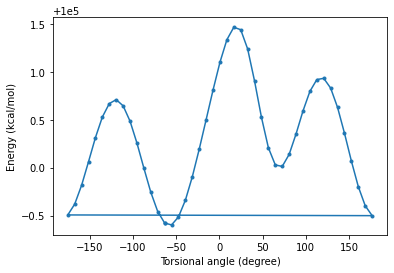

In [81]:
N = 46
ff = RDKitFF()
conf = mol6.GetConformer()
angle0 = conf.GetTorsionDeg(torsion1)
pos0 = conf.GetPositions()

energies = []
angles = []

for i in range(N):
    
    conf.SetPositions(pos0)
    conf.SetTorsionDeg(torsion1, angle0 + i * 360 / (N-1))
    ff.setup(mol6)
    ff.add_torsion_constraint(torsion1, value=1.0, relative=True, force_constant=1e5)
    angles.append(conf.GetTorsionDeg(torsion1))
    energies.append(ff.ff.CalcEnergy())
    
plt.plot(angles, energies, '.-')
plt.ylabel('Energy (kcal/mol)')
plt.xlabel('Torsional angle (degree)')